In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from pylab import rcParams

In [2]:
data = pd.read_excel("C:\\Users\\shaleens\\Desktop\\Projects\\TimeSeriesUdacity\\TS Udemy Vids\\Time Series 2\\Demand Forecasting Dataset\\train.xlsx")

In [3]:
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
data.set_index('date', inplace=True)

In [5]:
data.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [6]:
len(data)

913000

In [7]:
# Considering only the sales column initially to perform SARIMA model i.e. without exogeneous variable!

df = data.groupby(data.index).sum()[['sales']]

In [8]:
df.head()

,sales
date,
2013-01-01,13696
2013-01-02,13678
2013-01-03,14488
2013-01-04,15677
2013-01-05,16237


In [9]:
len(df)

1826

In [10]:
df.tail()

,sales
date,
2017-12-27,20378
2017-12-28,21885
2017-12-29,23535
2017-12-30,24988
2017-12-31,26420


In [11]:
len(pd.date_range('2013-01-01','2017-12-31',freq='D'))
# Since this matches our len(df) it means there is no date missing in the sequence!

1826

In [12]:
df.index.freq = 'D'

In [13]:
df.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='date', length=1826, freq='D')

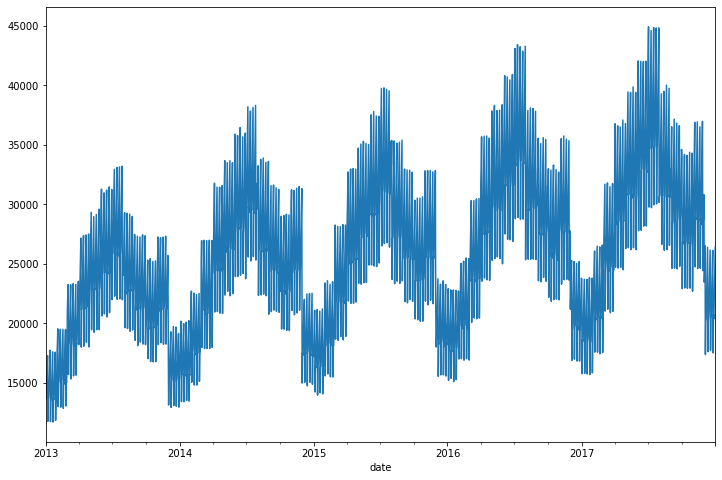

In [14]:
df['sales'].plot(figsize=(12,8))   # Daily data view

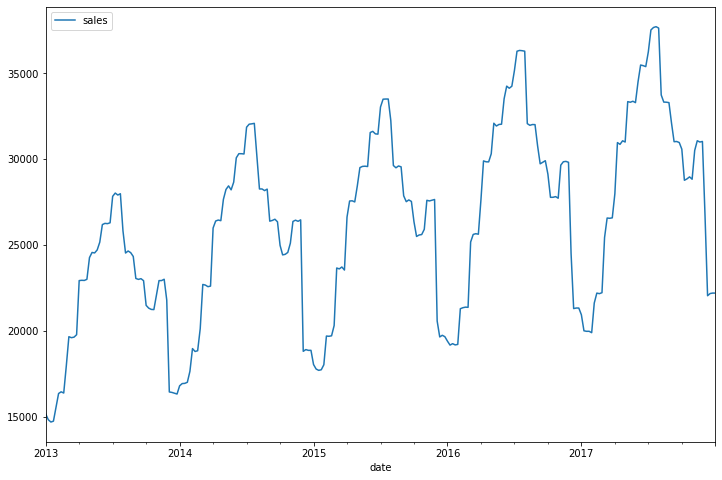

In [15]:
df_weekly = df[['sales']].resample(rule = 'W').mean()
df_weekly.plot(figsize=(12,8))  # weekly data view

In [16]:
df_weekly.index

DatetimeIndex(['2013-01-06', '2013-01-13', '2013-01-20', '2013-01-27',
               '2013-02-03', '2013-02-10', '2013-02-17', '2013-02-24',
               '2013-03-03', '2013-03-10',
               ...
               '2017-10-29', '2017-11-05', '2017-11-12', '2017-11-19',
               '2017-11-26', '2017-12-03', '2017-12-10', '2017-12-17',
               '2017-12-24', '2017-12-31'],
              dtype='datetime64[ns]', name='date', length=261, freq='W-SUN')

In [17]:
df_weekly.head()

,sales
date,
2013-01-06,15177.833333
2013-01-13,14843.142857
2013-01-20,14707.142857
2013-01-27,14756.857143
2013-02-03,15575.285714


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  import sys


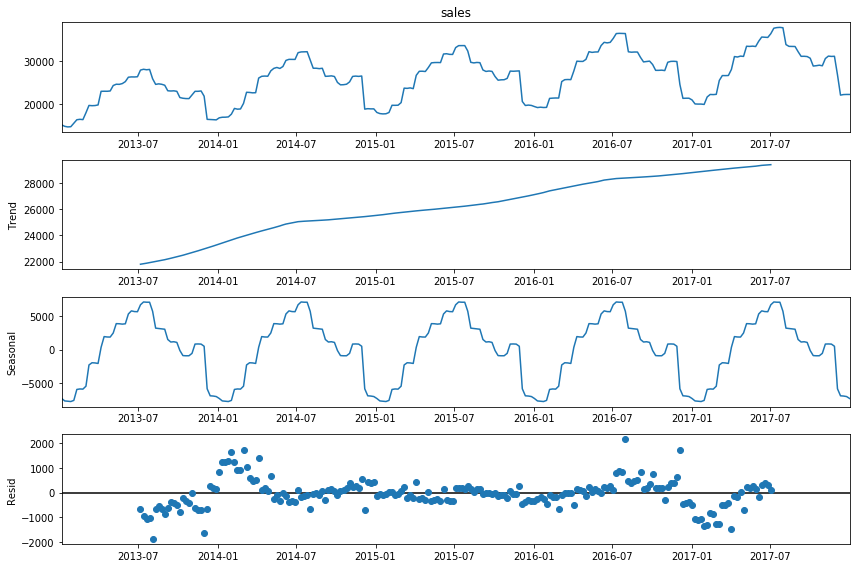

In [18]:
### Lets check out its ETS decomposition:

### Lets perform analysis on weekly level first, it will be easy to visualize:


rcParams['figure.figsize'] = 12,8
res = seasonal_decompose(df_weekly['sales'], model='add', freq= 52)
res.plot();

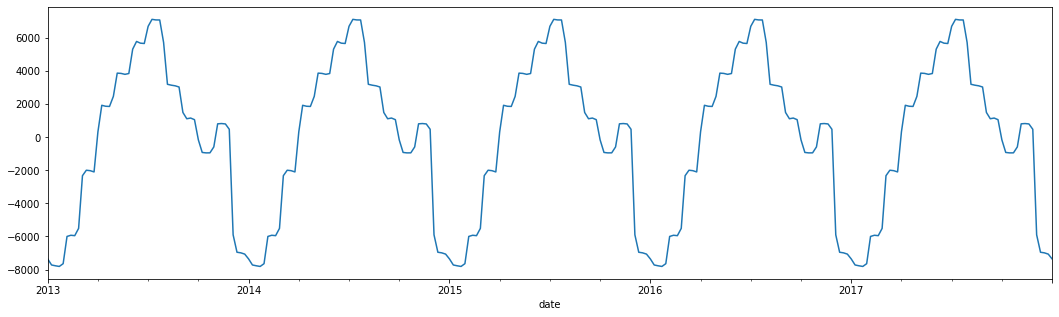

In [19]:
res.seasonal.plot(figsize=(18,5))

In [22]:
len(df_weekly)

261

In [23]:
df_weekly.head()

,sales
date,
2013-01-06,15177.833333
2013-01-13,14843.142857
2013-01-20,14707.142857
2013-01-27,14756.857143
2013-02-03,15575.285714


In [24]:
### Test for stationarity:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    '''
    Pass in a time series and an optional title, function returns an ADF report
    '''
    print(f'Augmented Dickey-fuller test: {title}')
    result = adfuller(series.dropna(), autolag='AIC') # dropna() handles differenced data
    
    labels = ['adf test stats','p-value', '# of lags', '# of observations']
    out = pd.Series(result[0:4], index=labels)
    
    for key,val in result[4].items():
        out[f'critical value ({key})'] = val
    
    print(out.to_string())
    
    if result[1] <= 0.05:
        print("Null Hypothesis rejected! Time series is stationary!")
    else:
        print("Failed to reject Null Hypothesis! Time Series is not stationary!")

In [25]:
adf_test(df_weekly)

Augmented Dickey-fuller test: 
adf test stats           -3.366657
p-value                   0.012149
# of lags                 4.000000
# of observations       256.000000
critical value (1%)      -3.456155
critical value (5%)      -2.872897
critical value (10%)     -2.572822
Null Hypothesis rejected! Time series is stationary!


In [26]:
## Lets split the weekly data to train and test set:

train_df = df_weekly[:238]
test_df = df_weekly[238:]      # taking 6 months i.e. 24 weeks as test data

In [28]:
### Lets try and get the parameter values of p,d,q and P,D,Q using auto_arima to apply SARIMA:
### Note that we acquire the best values using complete dataset itself:


stepwise_fit = auto_arima(df_weekly['sales'],seasonal=True, m=52, trace=True)

Performing stepwise search to minimize aic


C:\Users\shaleens\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: (2, 1, 2)x(1, 1, 1, 52) (constant=True); AIC=3057.058, BIC=3083.759, Time=44.751 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 52) (constant=True); AIC=3157.443, BIC=3164.118, Time=0.728 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 52) (constant=True); AIC=3065.589, BIC=3078.940, Time=10.991 seconds


C:\Users\shaleens\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: (0, 1, 1)x(0, 1, 1, 52) (constant=True); AIC=3063.477, BIC=3076.827, Time=13.728 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 52) (constant=False); AIC=3155.446, BIC=3158.784, Time=0.690 seconds


C:\Users\shaleens\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: (2, 1, 2)x(0, 1, 1, 52) (constant=True); AIC=3057.756, BIC=3081.119, Time=38.203 seconds


C:\Users\shaleens\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: (2, 1, 2)x(1, 1, 0, 52) (constant=True); AIC=3056.610, BIC=3079.972, Time=54.376 seconds
Fit ARIMA: (2, 1, 2)x(0, 1, 0, 52) (constant=True); AIC=3103.929, BIC=3123.954, Time=6.689 seconds


C:\Users\shaleens\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: (2, 1, 2)x(2, 1, 0, 52) (constant=True); AIC=3056.034, BIC=3082.734, Time=137.469 seconds


C:\Users\shaleens\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\shaleens\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: (2, 1, 2)x(2, 1, 1, 52) (constant=True); AIC=3058.898, BIC=3088.936, Time=148.299 seconds


C:\Users\shaleens\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: (1, 1, 2)x(2, 1, 0, 52) (constant=True); AIC=3057.959, BIC=3081.322, Time=116.319 seconds
Fit ARIMA: (2, 1, 1)x(2, 1, 0, 52) (constant=True); AIC=3063.230, BIC=3086.593, Time=96.697 seconds


C:\Users\shaleens\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: (3, 1, 2)x(2, 1, 0, 52) (constant=True); AIC=3054.806, BIC=3084.844, Time=158.046 seconds
Fit ARIMA: (3, 1, 2)x(1, 1, 0, 52) (constant=True); AIC=3054.879, BIC=3081.579, Time=54.840 seconds


C:\Users\shaleens\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\shaleens\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: (3, 1, 2)x(2, 1, 1, 52) (constant=True); AIC=3058.736, BIC=3092.111, Time=172.472 seconds
Near non-invertible roots for order (3, 1, 2)(2, 1, 1, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.992)


C:\Users\shaleens\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: (3, 1, 2)x(1, 1, 1, 52) (constant=True); AIC=3055.575, BIC=3085.613, Time=63.789 seconds
Fit ARIMA: (3, 1, 1)x(2, 1, 0, 52) (constant=True); AIC=3063.175, BIC=3089.875, Time=102.508 seconds


C:\Users\shaleens\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\shaleens\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\shaleens\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: (4, 1, 2)x(2, 1, 0, 52) (constant=True); AIC=3055.615, BIC=3088.990, Time=211.065 seconds
Fit ARIMA: (3, 1, 3)x(2, 1, 0, 52) (constant=True); AIC=3055.623, BIC=3088.998, Time=171.934 seconds


C:\Users\shaleens\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: (2, 1, 3)x(2, 1, 0, 52) (constant=True); AIC=3057.293, BIC=3087.331, Time=166.960 seconds


C:\Users\shaleens\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: (4, 1, 1)x(2, 1, 0, 52) (constant=True); AIC=3059.456, BIC=3089.494, Time=147.703 seconds


C:\Users\shaleens\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: (4, 1, 3)x(2, 1, 0, 52) (constant=True); AIC=3059.217, BIC=3095.930, Time=194.530 seconds
Near non-invertible roots for order (4, 1, 3)(2, 1, 0, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Total fit time: 2112.949 seconds


In [29]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  261
Model:             SARIMAX(3, 1, 2)x(2, 1, [], 52)   Log Likelihood               -1518.403
Date:                             Fri, 21 Feb 2020   AIC                           3054.806
Time:                                     20:39:10   BIC                           3084.844
Sample:                                          0   HQIC                          3066.952
                                             - 261                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.5751     18.145     -0.032      0.975     -36.138      34.987
ar.L1          0.5881      0.121      4.862      0.000       0.351       0.825
ar.L2         -0.3711      0.112     -3.325      0.001      -0.590      -0.152
ar.L3         -0.1603      0.107     -1.503      0.133      -0.369       0.049
ma.L1         -1.1250      0.107    -10.471      0.000      -1.336      -0.914
ma.L2          0.7903      0.119      6.629      0.000       0.557       1.024
ar.S.L52       0.5246      0.047     11.197      0.000       0.433       0.616
ar.S.L104     -0.1409      0.051     -2.783      0.005      -0.240      -0.042
sigma2      1.293e+05   9615.606     13.451      0.000     1.1e+05    1.48e+05
===================================================================================
Ljung-Box (Q):                       40.48   Jarque-Bera (JB):                42.47
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                             0.06
Prob(H) (two-sided):                  0.36   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [32]:
model = SARIMAX(train_df['sales'], order=(3,1,2),seasonal_order=(2,1,0,52),enforce_invertibility=False)

In [33]:
res = model.fit()

C:\Users\shaleens\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [34]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               sales   No. Observations:                  238
Model:             SARIMAX(3, 1, 2)x(2, 1, [], 52)   Log Likelihood               -1355.605
Date:                             Fri, 21 Feb 2020   AIC                           2727.210
Time:                                     21:16:58   BIC                           2752.973
Sample:                                 01-06-2013   HQIC                          2737.651
                                      - 07-23-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5690      0.153      3.710      0.000       0.268       0.870
ar.L2         -0.3789      0.130     -2.920      0.003      -0.633      -0.125
ar.L3         -0.1382      0.120     -1.149      0.250      -0.374       0.097
ma.L1         -1.0814      0.140     -7.742      0.000      -1.355      -0.808
ma.L2          0.7707      0.153      5.040      0.000       0.471       1.070
ar.S.L52       0.5516      0.055     10.094      0.000       0.445       0.659
ar.S.L104     -0.1593      0.051     -3.111      0.002      -0.260      -0.059
sigma2       1.37e+05   1.12e+04     12.279      0.000    1.15e+05    1.59e+05
===================================================================================
Ljung-Box (Q):                       39.89   Jarque-Bera (JB):                34.30
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               1.64   Skew:                             0.06
Prob(H) (two-sided):                  0.05   Kurtosis:                         5.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
start = len(train_df)
end = len(train_df) + len(test_df) - 1

pred = res.predict(start, end,typ='levels').rename("SARIMA predictions")

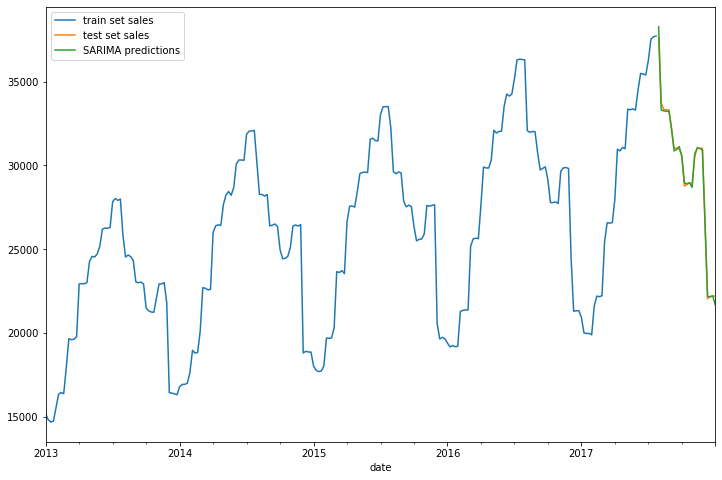

In [62]:
train_df['sales'].rename("train set sales").plot(legend = True, figsize=(12,8))
test_df['sales'].rename("test set sales").plot(legend=True)
pred.plot(legend = True)

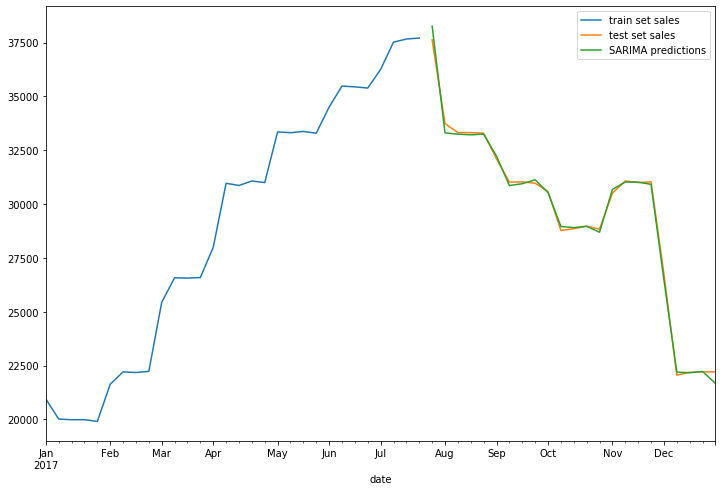

In [58]:
train_df['sales']['2017-01-01':].rename("train set sales").plot(legend = True, figsize=(12,8))
test_df['sales'].rename("test set sales").plot(legend=True)
pred.plot(legend = True)

In [38]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(test_df['sales'], pred))
rmse

225.32754217146118

###### We have attained a fairly less rmse with SARIMAX without introducing exogeneous variables.! 

In [40]:
test_df['sales'].mean()

29629.894409937886

In [41]:
pred.mean()

29604.958874555872

-----------------------

### Forecasting the future:

In [63]:
### Lets use the complete dataset to train the model:

final_model = SARIMAX(df_weekly['sales'],order=(3,1,2),seasonal_order=(2,1,0,52),enforce_invertibility=False)
final_res = final_model.fit()
final_pred = final_res.predict(start = len(df_weekly), end= len(df_weekly)+ 23, typ='levels').rename("Future forecast") 
# prediction next 6 months(23 since our data is in week)

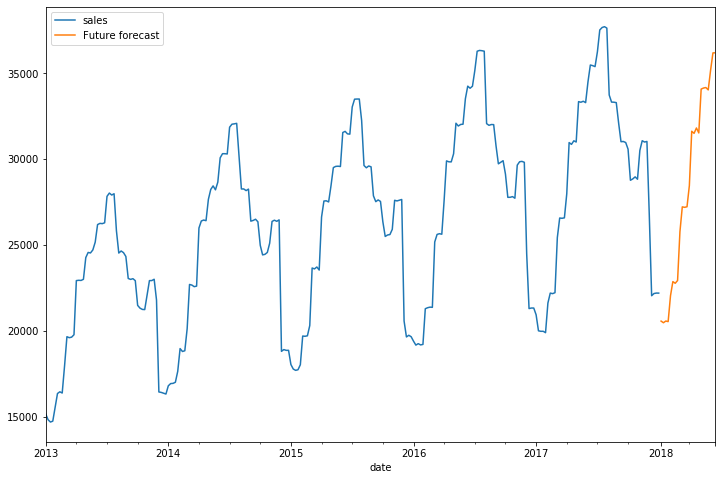

In [64]:
df_weekly['sales'].plot(legend=True, figsize=(12,8))
final_pred.plot(legend=True)

-------------

### Thought:

In [65]:
### Note: We may consider generating new features like:

In [72]:
data['dayofmonth'] = data.index.day
data['dayofyear'] = data.index.dayofyear
data['dayofweek'] = data.index.dayofweek
data['month'] = data.index.month
data['year'] = data.index.year
data['weekofyear'] = data.index.weekofyear
data.head()

,store,sales,dayofmonth,dayofyear,dayofweek,month,year,weekofyear
date,,,,,,,,
2013-01-01,1,13,1,1,1,1,2013,1
2013-01-02,1,11,2,2,2,1,2013,1
2013-01-03,1,14,3,3,3,1,2013,1
2013-01-04,1,13,4,4,4,1,2013,1
2013-01-05,1,10,5,5,5,1,2013,1


### REFER: StoreItemDemandForecastingChallenge_Git.ipynb for more ideas.